<a href="https://colab.research.google.com/github/MaslovAleksey/Bird-voice-recognition/blob/main/Bird_voice_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Распознавание голосов птиц**

## **1) Техническое описание работы**

* ### **Постановка задачи:**
> #### Реализовать алгоритм многоклассовой классификации голосов птиц, основываясь на аудиозаписях.

---

* ### **Используемые библиотеки и модули:**
> #### zipfile, colab, pandas, numpy, os, random, matplotlib, keras, sklearn, IPython, librosa; 

--- 

* ### **Особенности набора данных**
> #### 1.   Данные включают в себя очищенные от шума аудиозаписи, содержащие голоса различных птиц и таблицу, описывающую связь каждой аудиозаписи с конкретным классом птицы;
> #### 2.   Наблюдается некоторая разбалансировка по времени длительности аудиозаписей, принадлижащих различным видам птиц.

--- 

* ### **Особенности реализации алгоритма:**
> #### 1.   В качестве анализируемых параметров аудиозаписей выступают как одномерные характеристики, так и двумерные;
> #### 2.   На основании каждой аудиозаписи формируются отрезки данных определённой длины (*length*) и с заданным шагом смещения (*step*);
> #### 3.   Разбиение набора данных на выборки происходит посредством создания масок (*train*, *val*, *test*);
> #### 4.   Алгоритм распознавания включает в себя параллельную обработку данных, имеющих различные размерности, и их дальнейшее совмещение в один вектор;
> #### 5.   Сохранение лучших весов модели происходит на Google диск.

## **2.) Подготока данных**

### **Подключение необходимых библиотек**

In [ ]:
import zipfile
from google.colab import drive
import pandas as pd
import numpy as np
import os
import random 
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.models import Model # инструменты для функционального API
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Input, concatenate # необходимые слои
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences # приведение данных к одному размеру
from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler

from IPython.display import Audio  # воспроизведение аудиофайлов

import librosa                     # параметризация аудио
import librosa.feature             # инструменты для параметризации

### **Загрузка данных**

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
bi = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/UAI/28.) Bird voice recognition/Data/база пения птиц. 88 классов.zip', 'r')
bi.extractall()

In [ ]:
data_bird = pd.read_csv('/content/birdsong_metadata.csv', usecols=["file_id", "english_cname"])

In [ ]:
print("\033[1mИнформация об аудиозаписях\033[0m")
data_bird.head(10)

Информация об аудиозаписях


,file_id,english_cname
0,132608,Common Redpoll
1,132611,Common Redpoll
2,35068,Common Redpoll
3,82715,Marsh Warbler
4,64685,Marsh Warbler
5,64686,Marsh Warbler
6,120664,Sedge Warbler
7,120666,Sedge Warbler
8,76767,Sedge Warbler
9,124052,Eurasian Reed Warbler


### **Глобальные переменные**

In [ ]:
num_classes = data_bird["english_cname"].nunique() # число уникальных классов птиц
names_classes = data_bird["english_cname"].unique() # список классов птиц
path_songs = "/content/songs/songs"

In [ ]:
print(f"\033[1mЧисло уникальных классов птиц - {num_classes}\033[0m")
print(f"\033[1mСписок классов птиц:\033[0m\n{names_classes}")

Число уникальных классов птиц - 88
Список классов птиц:
['Common Redpoll' 'Marsh Warbler' 'Sedge Warbler' 'Eurasian Reed Warbler'
 'Long-tailed Tit' 'Eurasian Skylark' 'Meadow Pipit' 'Tree Pipit'
 'Common Swift' 'Canada Goose' 'Dunlin' 'European Nightjar'
 'European Goldfinch' 'Eurasian Treecreeper' 'European Greenfinch'
 'Black-headed Gull' 'Western Jackdaw' 'Rock Dove' 'Stock Dove'
 'Common Wood Pigeon' 'Northern Raven' 'Carrion Crow' 'Rook'
 'Common Cuckoo' 'Eurasian Blue Tit' 'Common House Martin'
 'Great Spotted Woodpecker' 'Black Woodpecker' 'Corn Bunting'
 'Yellowhammer' 'Common Reed Bunting' 'European Robin' 'Common Chaffinch'
 'Eurasian Coot' 'Common Snipe' 'Common Moorhen' 'Eurasian Jay'
 'Red-throated Loon' 'Eurasian Oystercatcher' 'Barn Swallow'
 'Eurasian Wryneck' 'Willow Ptarmigan' 'European Herring Gull'
 'Common Linnet' 'River Warbler' 'Red Crossbill' 'Common Nightingale'
 'European Bee-eater' 'African Pied Wagtail' 'Western Yellow Wagtail'
 'Spotted Flycatcher' 'Eurasi

## **3.) Необходимые функции**

### **Создание словарей с данными**

In [ ]:
def create_dicts(data_bird):
  # 1.) Словарь "название класса - индекс"
  class_ind = {names_classes[i]:i for i in range(num_classes)}

  # 2.) Словари "id - название класса" и "название класса - ides"
  id_class = {}
  class_ides = {}
  data_id = list(data_bird.groupby("english_cname")) # информация о принадлежности аудиозаписей к определённому классу
  for block in data_id:
    cl = block[0] # название класса
    ides = block[1]["file_id"].values # соответствующие индексы
    for id in ides:
      id_class[id] = cl

    class_ides[cl] = ides

  return class_ind, id_class, class_ides

### **Извлечение признаков аудиозаписи**

In [ ]:
'''

Виды признаков аудиозаписей
1.) Одномерные:
- среднеквадратичная амплитуда
- средняя частота смены знака сигнала
- среднее значение спектрального центроида
- среднее значение спектрального спада частоты (85%)
- среднее значение ширины полосы частот

2.) Двумерные:
- мел-частотные кепстральные коэффициенты сигнала
- частоты цветности

'''

def get_features(x, sr):
  x_base = []

  rms = np.mean(librosa.feature.rms(x)) # среднеквадратичная амплитуда
  zcr = np.mean(librosa.feature.zero_crossing_rate(x)) # средняя частота смены знака сигнала
  spec_cent = np.mean(librosa.feature.spectral_centroid(x, sr)) # среднее значение спектрального центроида
  rolloff = np.mean(librosa.feature.spectral_rolloff(x, sr)) # среднее значение спектрального спада частоты (85%)
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(x, sr)) # среднее значение ширины полосы частот


  param = [rms, zcr, spec_cent, rolloff, spec_bw]

  for p in param:
    x_base.append(p)

  x_mfccs = librosa.feature.mfcc(x, sr) # мел-частотные кепстральные коэффициенты сигнала

  x_chroma = librosa.feature.chroma_stft(x, sr) # частоты цветности


  return x_base, x_mfccs, x_chroma

### **Создание наборов данных**

In [ ]:
def create_datasets(data_bird, class_ind, id_class, length, step):
  x_data_base = [] # значения основных параметров
  x_data_mfccs = [] # мел-частотные кепстральные коэффициенты
  x_data_chroma = [] # частоты цветности
  y_data = []
  num_frames = {names_classes[i]:0 for i in range(num_classes)} # количество отрезков разбиения

  records = os.listdir(path_songs)

  # 1.) Извлечение признаков аудиозаписи

  for r in records:
    id = r.replace('xc', '')
    id = int(id.replace('.flac', '')) # индекс текущей аудиозаписи
    cl = id_class[id] # класс текущей аудиозаписи
    ind = class_ind[cl] # индекс текущей аудиозаписи

    curr_y = utils.to_categorical(ind, num_classes)

    voice_path = path_songs + '/' + r
    y_rec, sr = librosa.load(voice_path, mono=True)
    dur = np.round(len(y_rec)/sr, decimals=2) # продолжительность аудиозаписи (сек)
    curr_num_frames = int(np.floor((dur - length)/step)) + 1 # число отрезков разбиения (не используем крайний неполный отрезок данных)
    num_frames[cl] += curr_num_frames # вычисление числа отрезков разбиения для каждого класса

    # print(f"\nДлина записи - {dur}")
    # print(f"Число отрнезков - {curr_num_frames}")

    for i in range(curr_num_frames):

      curr_y_rec = y_rec[(i*step*sr):(i*step+length)*sr] # анализируемый отрезок данных
      x_base, x_mfccs, x_chroma = get_features(curr_y_rec, sr) # извлечение признаков аудио

      x_data_base.append(x_base)
      x_data_mfccs.append(x_mfccs)
      x_data_chroma.append(x_chroma)
      y_data.append(curr_y)
  
  # Устранение разбалансировки базы
  # max_frames = max(num_frames.values()) # максимальное число отрезков разбиения
  # for cl, num_fr in num_frames.items():
  #   need_frames = max_frames - num_fr # необходимое число отрезков для добавления
  #   need_ides = class_ides[cl] # id аудиозаписей данного класса
  #   k = 0 
  #   while k < need_frames:
  #     id = random.choice(need_ides) # случайный выбор аудиозаписи
  #     print(id)
  #     r = f"xc{id}.flac" # название файла аудиозаписи
  #     voice_path = path_songs + '/' + r
  #     y_rec, sr = librosa.load(voice_path, mono=True)
  #     dur = np.round(len(y_rec)/sr, decimals=2) # продолжительность аудиозаписи (сек)
  #     if (dur < length):
  #       break
  #     start = random.randint(0, int(dur)-(length)) # выбор стартовой секунды отсчёта
  #     need_y_rec = y_rec[start*sr : (start+length)*sr]

  #     x_base, x_mfccs, x_chroma = get_features(need_y_rec, sr) # извлечение признаков аудио

  #     x_data_base.append(x_base)
  #     x_data_mfccs.append(x_mfccs)
  #     x_data_chroma.append(x_chroma)
  #     y_data.append(curr_y)
      
  #     k += 1


  # 2.) Преобразование к nd.array
  x_data_base = np.array(x_data_base)
  x_data_mfccs = np.array(x_data_mfccs)
  x_data_chroma = np.array(x_data_chroma)
  y_data = np.array(y_data)
    
  return x_data_base, x_data_mfccs, x_data_chroma, y_data, num_frames

### **Формирование архитектуры нейронной сети**

In [ ]:
'''

1.) Нейронная сеть представляет собой совокупность 3-х каналов обработки данных:
- линейные характеристики;
- мел-частотные кепстральные коэффициенты
- частоты цветности

2.) Обработка линейных характеристик происходит путём полносвязных Dence слоёв;

3.) Двумерные характеристики обрабатываются свёрточными блоками:
- BatchNormalization()
- Conv2D()
- Conv2D()
- MaxPooling2D()
- Dropout()

'''

def create_model(base_length, mfcc_shape, chroma_shape):

  # 1.) Линейные характеристики

  input_base = Input((base_length, ), name='base')

  base = Dense(256, activation='relu')(input_base)
  base = Dense(512, activation='relu')(base)

  # 2.) Мел-частотные кепстральные коэффициенты
  input_mfcc = Input(shape=mfcc_shape, name='mfcc') # shape - (20, 173, 1)

  mfcc = BatchNormalization()(input_mfcc)
  mfcc = Conv2D(filters=32, kernel_size=(3,3), padding='same', activation="relu")(mfcc) # shape - (20, 173, 32)
  mfcc = Conv2D(filters=32, kernel_size=(3,3), padding='same', activation="relu")(mfcc)
  mfcc = MaxPooling2D(pool_size=(2,3), strides = (2,3), padding='valid')(mfcc) # shape - (10, 64, 32)
  mfcc = Dropout(0.3)(mfcc)

  mfcc = BatchNormalization()(mfcc)
  mfcc = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation="relu")(mfcc) # shape - (10, 57, 64)
  mfcc = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation="relu")(mfcc)
  mfcc = MaxPooling2D(pool_size=(2,3), strides = (2,3), padding='valid')(mfcc) # shape - (5, 19, 64)
  mfcc = Dropout(0.3)(mfcc)

  mfcc = Flatten()(mfcc) # length - 6080
  mfcc = BatchNormalization()(mfcc)
  mfcc = Dense(1024, activation="relu")(mfcc)
  mfcc = Dropout(0.3)(mfcc)
  mfcc = Dense(512, activation="relu")(mfcc)

  # 3.) Частоты цветности
  input_chroma = Input(shape=chroma_shape, name='chroma') # shape - (12, 173, 1)

  chroma = BatchNormalization()(input_chroma)
  chroma = Conv2D(filters=32, kernel_size=(3,3), padding='same', activation="relu")(chroma)
  chroma = Conv2D(filters=32, kernel_size=(3,3), padding='same', activation="relu")(chroma)
  chroma = MaxPooling2D(pool_size=(1,4), strides = (1,4), padding='valid')(chroma) # shape - (12, 43, 32)
  chroma = Dropout(0.3)(chroma)

  chroma = BatchNormalization()(chroma)
  chroma = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation="relu")(chroma) # shape - (12, 43, 64)
  chroma = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation="relu")(chroma)
  chroma = MaxPooling2D(pool_size=(2,3), strides = (2,3), padding='valid')(chroma) # shape - (6, 14, 64)
  chroma = Dropout(0.3)(chroma)

  chroma = Flatten()(chroma) # length - 5376
  chroma = BatchNormalization()(chroma)
  chroma = Dense(1024, activation="relu")(chroma)
  chroma = Dropout(0.3)(chroma)
  chroma = Dense(512, activation="relu")(chroma)

  # 4.) Совмещение данных
  merge = layers.concatenate([base, mfcc, chroma]) # length - 1536
  output = Dense(units=num_classes, activation="softmax")(merge)

  model = Model(inputs = [input_base, input_mfcc, input_chroma], outputs = output)

  return model 

### **Формирование масок разбиения данных**

In [ ]:
'''

Маски разбиения формируются на основании равномерного распределения.

'''

def create_masks(val_per, test_per, num_frames):
  values = np.random.sample(num_frames)
  val_per = val_per/100
  test_per = test_per/100

  train_mask = values < (1 - val_per - test_per)
  val_mask = (values >= (1 - val_per - test_per)) & (values < (1 - test_per))
  test_mask = values >= (1 - test_per)

  return train_mask, val_mask, test_mask  

### **Callback**

In [ ]:
'''

Параметры  реализации Callback:
- сохранение лучших весов модели;
- оценивание val_accuracy;
- запись на Google диск;

'''

def get_callback(lr, start_ep, end_ep):
  checkpoint_filepath = f"/content/drive/MyDrive/Colab Notebooks/UAI/28.) Bird voice recognition/Weights/best_weights_lr_{lr}_ep_{start_ep}_{end_ep}.h5"

  best_weights = ModelCheckpoint(
      filepath = checkpoint_filepath,
      monitor = "val_accuracy", 
      save_best_only = True,
      save_weights_only = True,
      mode = "max"
      )

  return best_weights

### **Визуализация процесса обучения**

In [ ]:
def plot_graphs(history):
  # График точности обученной модели
  fig, ax = plt.subplots(figsize = (12,7))
  ax.plot(history.history['accuracy'], label = "тренировочные данные")
  ax.plot(history.history['val_accuracy'], label = "проверочные данные")
  ax.set_title("Точность обученной модели", size = 16, pad = 20)
  ax.set_xlabel("Число эпох", size = 12)
  ax.set_ylabel("accuracy", size = 12)
  ax.legend(prop={'size': 12})
  plt.show()

  # График ошибки обученной модели
  fig, ax = plt.subplots(figsize = (12,7))
  ax.plot(history.history['loss'], label = "тренировочные данные")
  ax.plot(history.history['val_loss'], label = "проверочные данные")
  ax.set_title("Ошибка обученной модели", size = 16, pad = 20)
  ax.set_xlabel("Число эпох", size = 12)
  ax.set_ylabel("Ошибка", size = 12)
  ax.legend(prop={'size': 12})
  plt.show()

### **Реализация процесса обучения нейронной сети**

In [ ]:
def model_training(model, all_data, masks):
  
  # 1.) Компиляция нейронной сети
  print(f"\033[1mДанные для компиляции:\033[0m")
  
  lr=float(input("Шаг обучения - "))
  loss = input("Функция ошибки - ") # "categorical_crossentropy"
  metrics = [input("Метрика точности - ")] # accuracy

  model.compile(
      optimizer = Adam(learning_rate=lr),
      loss = loss,
      metrics = metrics
  )


  # 2.) Обучение нейронной сети
  print(f"\n\033[1mДанные для обучения:\033[0m")
  training_data = {}
  training_data["x"] = {"base":all_data["base"][masks["train"]], "mfcc":all_data["mfcc"][masks["train"]], "chroma":all_data["chroma"][masks["train"]]}
  training_data["y"] = all_data["y_data"][masks["train"]]
  training_data["batch_size"] = int(input("Batch size - "))
  training_data["epochs"] = int(input("Число эпох обучения - "))
  training_data["verbose"] = 1
  training_data["initial_epoch"] = int(input("Стартовая эпоха обучения - "))
  training_data["validation_data"] = [{"base":all_data["base"][masks["val"]], "mfcc":all_data["mfcc"][masks["val"]], "chroma":all_data["chroma"][masks["val"]]}, all_data["y_data"][masks["val"]]]
  use_callbacks = input("Сохранять ли лучшие веса модели? (да/нет) -  ")
  if (use_callbacks == "да"):
    training_data["callbacks"] = get_callback(lr, training_data["initial_epoch"], training_data["epochs"])

  use_weights = input("Необходимо ли использовать предобученные веса (да/нет) - ")
  if (use_weights) == "да":
    weights_path = input("Путь к предобученным весам - ")
    model.load_weights(weights_path)

  history = model.fit(**training_data)


  # 3.) Построение графиков обучения
  plot_graphs(history)


### **Распознавание тестововой выборки**

In [ ]:
def test_recognition(model, all_data, masks):
  use_weights = input("Необходимо ли использовать предобученные веса (да/нет) - ")
  if (use_weights) == "да":
    weights_path = input("Путь к предобученным весам - ")
    model.load_weights(weights_path)

  base_test = all_data["base"][masks["test"]]
  mfcc_test = all_data["mfcc"][masks["test"]]
  chroma_test = all_data["chroma"][masks["test"]]

  y_pred = model.predict([base_test, mfcc_test, chroma_test])
  y_pred = np.argmax(y_pred, axis=-1) # предсказанный набор классов
  y_real = np.argmax(all_data["y_data"][masks["test"]], axis=-1) # истинный набор классов

  num_test = np.sum(masks["test"]) # общее число данных для анализа
  num_acc =  np.sum(y_pred == y_real) # число верных ответов

  accuracy = np.round(num_acc/num_test*100, decimals=2)

  print(f"\033[1mТочность распознавания модели на тестовой выборке - {accuracy} %\033[0m")

## **4.) Реализация алгоритма распознавания**

### **Формирование словарей данных**

In [ ]:
class_ind, id_class, class_ides = create_dicts(data_bird)

In [ ]:
cl = input("Введите класс птицы - ")
print(f"\033[1mId аудозаписей, соответствующих данному классу\033[0m - {class_ides[cl]}")

Введите класс птицы - Eurasian Tree Sparrow
Id аудозаписей, соответствующих данному классу - [143465  90122  43764]


In [ ]:
rand_voice = random.choice(os.listdir(path_songs)) # выбор случайной аудиозаписи
rand_path = path_songs + '/' + random.choice(os.listdir(path_songs)) # путь к случайной аудиозаписи
rand_id = rand_voice.replace('xc', '')
rand_id = int(rand_id.replace('.flac', ''))
print(f"Запись голоса птицы - \033[1m{id_class[rand_id]}\033[0m")
Audio(rand_path)

Запись голоса птицы - Spotted Flycatcher


### **Формирование наборов данных**

In [ ]:
length = int(input("Длина отрезка разбиения (сек) - "))
step = int(input("Шаг разбиения (сек) - "))

Длина отрезка разбиения (сек) - 4
Шаг разбиения (сек) - 4


In [ ]:
x_base, x_mfcc, x_chroma, y_data, num_frames = create_datasets(data_bird, class_ind, id_class, length, step)

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [ ]:
print(f"\033[1mShape of x_base\033[0m - {x_base.shape}")
print(f"\033[1mShape of x_mfcc\033[0m - {x_mfcc.shape}")
print(f"\033[1mShape of x_chroma\033[0m - {x_chroma.shape}")
print(f"\033[1mShape of y_data\033[0m - {y_data.shape}")

Shape of x_base - (4304, 5)
Shape of x_mfcc - (4304, 20, 173)
Shape of x_chroma - (4304, 12, 173)
Shape of y_data - (4304, 88)


In [ ]:
max_num_frames = np.max(list(num_frames.values()))
num_need_frames = np.sum([(max_num_frames - val) for val in list(num_frames.values())])
print(f"\033[1mМаксимальное число отрезков аудио, соответствующее определённому классу\033[0m - {max_num_frames}")
print(f"\033[1mНеобходимое количетсво отрезков аудио для уравнивания классов\033[0m - {num_need_frames}")

Максимальное число отрезков аудио, соответствующее определённому классу - 186
Необходимое количетсво отрезков аудио для уравнивания классов - 12064


In [ ]:
# Словарь, содержащий наборы данных
all_data = {}
all_data["base"] = x_base
all_data["mfcc"] = x_mfcc
all_data["chroma"] = x_chroma
all_data["y_data"] = y_data

### **Создание масок разбиения**

In [ ]:
test_per = int(input("Процент тестовой выборки - "))
val_per = int(input("Процент тренировочной выборки - "))
num_frames = x_base.shape[0] # общий объём данных для обучения

Процент тестовой выборки - 5
Процент тренировочной выборки - 15


In [ ]:
train_mask, val_mask, test_mask = create_masks(val_per, test_per, num_frames)

In [ ]:
print(f"\033[1mОбъём тренировочной выборки\033[0m - {np.sum(train_mask)}")
print(f"\033[1mОбъём проверочной выборки\033[0m - {np.sum(val_mask)}")
print(f"\033[1mОбъём тестовой выборки\033[0m - {np.sum(test_mask)}")

Объём тренировочной выборки - 3451
Объём проверочной выборки - 640
Объём тестовой выборки - 213


In [ ]:
# Словарь, содержащий маски разбиения
masks = {}
masks["train"] = train_mask
masks["val"] = val_mask
masks["test"] = test_mask

### **Архитектура нейронной сети**

In [ ]:
# Размерности входных данных 
base_length = x_base.shape[-1]
mfcc_shape = np.expand_dims(x_mfcc[0], axis=-1).shape
chroma_shape = np.expand_dims(x_chroma[0], axis=-1).shape

In [ ]:
model = create_model(base_length, mfcc_shape, chroma_shape)

In [ ]:
print("\033[1mИнформавция о параметрах модели\033[0m")
model.summary()

Информавция о параметрах модели
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mfcc (InputLayer)              [(None, 20, 173, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 chroma (InputLayer)            [(None, 12, 173, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 20, 173, 1)  4           ['mfcc[0][0]']                   
 alization)                                                   

Структура модели


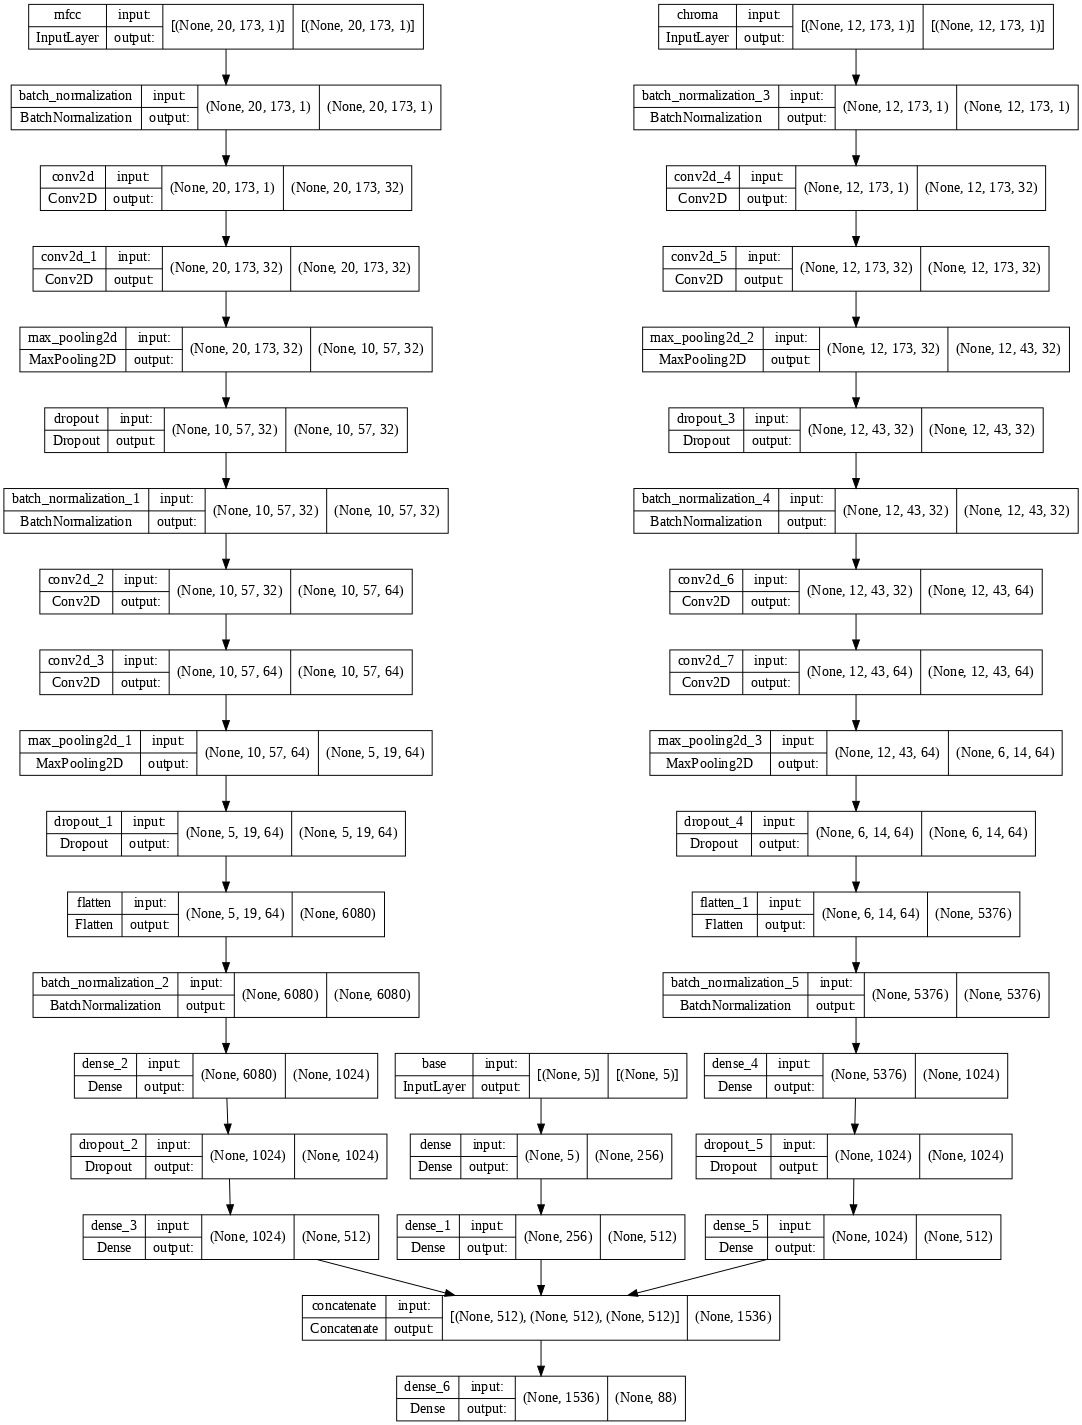

In [ ]:
print("\033[1mСтруктура модели\033[0m")
plot_model(model, dpi=70, show_shapes=True)

### **Процесс обучения нейронной сети (1-й этап)**

Данные для компиляции:
Шаг обучения - 1e-5
Функция ошибки - categorical_crossentropy
Метрика точности - accuracy

Данные для обучения:
Batch size - 64
Число эпох обучения - 200
Стартовая эпоха обучения - 0
Сохранять ли лучшие веса модели? (да/нет) -  да
Необходимо ли использовать предобученные веса (да/нет) - нет
Epoch 1/200
54/54 [==============================] - 4s 47ms/step - loss: 309.1246 - accuracy: 0.0122 - val_loss: 267.2497 - val_accuracy: 0.0063
Epoch 2/200
54/54 [==============================] - 2s 39ms/step - loss: 206.9711 - accuracy: 0.0142 - val_loss: 189.2159 - val_accuracy: 0.0141
Epoch 3/200
54/54 [==============================] - 2s 39ms/step - loss: 142.6526 - accuracy: 0.0212 - val_loss: 130.9294 - val_accuracy: 0.0172
Epoch 4/200
54/54 [==============================] - 2s 34ms/step - loss: 96.3178 - accuracy: 0.0197 - val_loss: 89.5443 - val_accuracy: 0.0156
Epoch 5/200
54/54 [==============================] - 2s 39ms/step - loss: 65.9597 - accuracy: 0.0385 - 

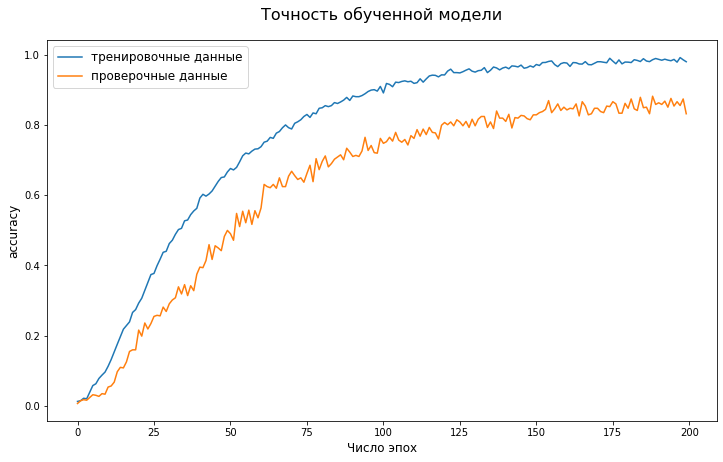

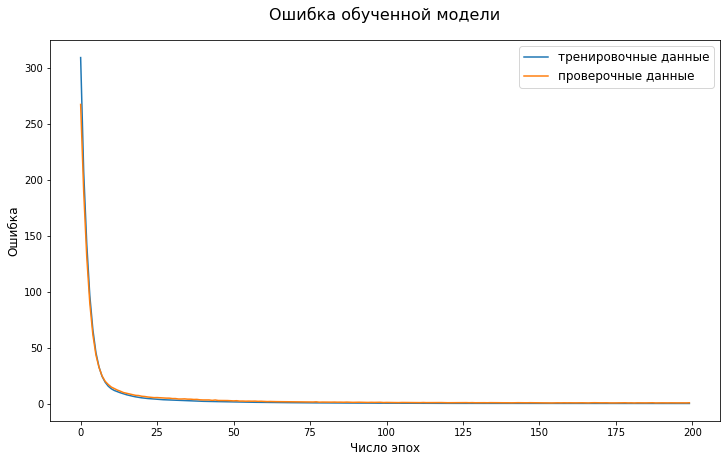

In [ ]:
model_training(model, all_data, masks)

### **Процесс обучения нейронной сети (2-й этап)**

Данные для компиляции:
Шаг обучения - 1e-6
Функция ошибки - categorical_crossentropy
Метрика точности - accuracy

Данные для обучения:
Batch size - 64
Число эпох обучения - 250
Стартовая эпоха обучения - 200
Сохранять ли лучшие веса модели? (да/нет) -  да
Необходимо ли использовать предобученные веса (да/нет) - да
Путь к предобученным весам - /content/drive/MyDrive/Colab Notebooks/UAI/28.) Bird voice recognition/Weights/best_weights_lr_1e-05_ep_0_200.h5
Epoch 201/250
54/54 [==============================] - 4s 46ms/step - loss: 0.0206 - accuracy: 0.9959 - val_loss: 0.4669 - val_accuracy: 0.8922
Epoch 202/250
54/54 [==============================] - 2s 34ms/step - loss: 0.0185 - accuracy: 0.9968 - val_loss: 0.4919 - val_accuracy: 0.8828
Epoch 203/250
54/54 [==============================] - 2s 39ms/step - loss: 0.0177 - accuracy: 0.9974 - val_loss: 0.4610 - val_accuracy: 0.8969
Epoch 204/250
54/54 [==============================] - 2s 34ms/step - loss: 0.0182 - accuracy: 0.9965 - val_lo

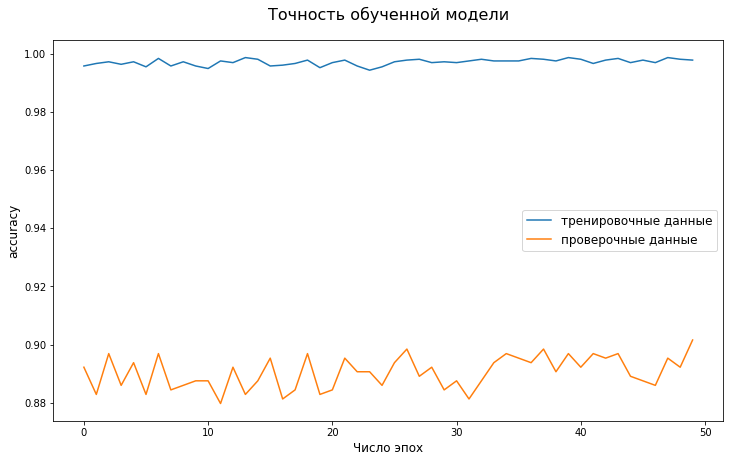

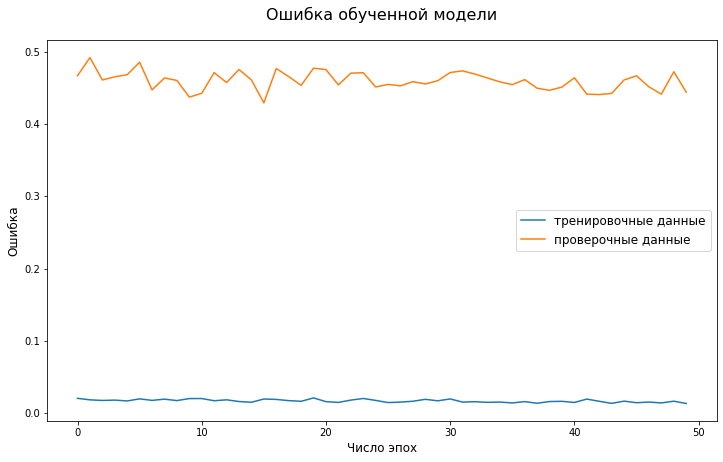

In [ ]:
model_training(model, all_data, masks)

### **Оценка качества сети на тестовой выборке**

In [ ]:
test_recognition(model, all_data, masks)

Необходимо ли использовать предобученные веса (да/нет) - нет
Точность распознавания модели на тестовой выборке - 87.79 %


## **5.) Выводы по работе**
> #### 1.   При разбиении аудио на отдельные отрезки не стоит анализировать последний участок, так как он короче всех остальных, что приведёт к различиям в длине *mfcc* и *chroma* признаков по сравнению с остальными отрезками.
> #### 2.   Попытка сбалансировать базу данных путём дополнения всех классов до равного количества отрезков занимает более 2 часов.
> #### 3.   При передаче типа оптимизатора в метод *model.compile()* при помощи разименованного словаря получаем ошибку в процессе вычисления обратного распространения ошибки *self.optimizer.minimize(loss, self.trainable_variables, tape=tape)*. В данном случае необходима непосредственная передача типа оптимизатора.